In [1]:

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2

from keras.applications.imagenet_utils import _obtain_input_shape
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.callbacks import *
# from keras_contrib.applications import densenet

/Users/wwymak/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
import scipy
from PIL import Image
from skimage.transform import resize
from imageio import imread

In [3]:
def fcn_vgg_8(input_shape, num_classes, weight_decay=5e-4):
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    vgg_conv3_out = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(vgg_conv3_out)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    vgg_conv4_out = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(vgg_conv4_out)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    vgg_conv5_out = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # convert dense layers to fully conv layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(vgg_conv5_out)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    conv7_out = Conv2D(num_classes, (1, 1), activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay), name='decoder_conv7')(x)   
    
    # decoder network
    vgg_conv4_conv1x1 = Conv2D(num_classes, (1, 1), activation='relu', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay),
                              name="layer4_conv1x1")(vgg_conv4_out)
    
    vgg_conv3_conv1x1 = Conv2D(num_classes, (1, 1), activation='relu', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay),
                              name="layer3_conv1x1")(vgg_conv3_out)
    
    upsample1 = Conv2DTranspose(num_classes, kernel_size=4, strides=(2,2), padding='same', kernel_regularizer=l2(weight_decay), name='upsample_1')(conv7_out)
    
    skip1 = Add()([upsample1, vgg_conv4_conv1x1])
    upsample2 = Conv2DTranspose(num_classes, kernel_size=4, strides=(2,2), padding='same', kernel_regularizer=l2(weight_decay), name='upsample_2')(skip1)
    
    skip2 = Add()([upsample2, vgg_conv3_conv1x1])
    upsample3 = Conv2DTranspose(num_classes, kernel_size=16, strides=(8,8), padding='same', kernel_regularizer=l2(weight_decay), name='upsample_3')(skip2)
    
    model = Model(img_input, upsample3)

    weights_path = os.path.expanduser(os.path.join('~', '.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'))
    model.load_weights(weights_path, by_name=True)
    return model

In [36]:
# https://github.com/aurora95/Keras-FCN/blob/master/utils/loss_function.py
def softmax_sparse_crossentropy_ignoring_last_label(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    log_softmax = tf.nn.log_softmax(y_pred)

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1]+1)
    unpacked = tf.unstack(y_true, axis=-1)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    cross_entropy = -K.sum(y_true * log_softmax, axis=1)
    cross_entropy_mean = K.mean(cross_entropy)

    return cross_entropy_mean


# Softmax cross-entropy loss function for coco segmentation
# and models which expect but do not apply sigmoid on each entry
# tensorlow only
def binary_crossentropy_with_logits(ground_truth, predictions):
    return K.mean(K.binary_crossentropy(ground_truth,
                                        predictions,
                                        from_logits=True),
                  axis=-1)
def sparse_accuracy_ignoring_last_label(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    y_pred = K.reshape(y_pred, (-1, nb_classes))

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)),
                       nb_classes + 1)
    unpacked = tf.unstack(y_true, axis=-1)
    legal_labels = ~tf.cast(unpacked[-1], tf.bool)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    return K.sum(tf.to_float(legal_labels & K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))) / K.sum(tf.to_float(legal_labels))


In [6]:
def fcn_binary_crossentropy(y_true, y_pred, from_logits=False):
    pred_shape = K.int_shape(y_pred)
    true_shape = K.int_shape(y_true)
    y_pred_reshaped = K.reshape(y_pred, (-1, 2))
    y_true_reshaped = K.reshape(y_true, (-1, 2))

    result = K.binary_crossentropy(y_pred_reshaped, y_true_reshaped,
                                   from_logits=from_logits)
    result = K.mean(result, axis=-1)

    if len(true_shape) >= 3:
        return K.reshape(result, true_shape[:-1])
    else:
        return result
    
def fcn_binary_crossentropy_with_regularisation(y_true, y_pred, from_logits=False):
    loss1 = fcn_binary_crossentropy(y_true, y_pred, from_logits=from_logits)
    loss2 = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) + 5e-4 + K.sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    
    return K.sum(loss1, loss2)

def pixelwise_crossentropy(target, output):
    output = tf.clip_by_value(output, 10e-8, 1. - 10e-8)
    return - tf.reduce_sum(target * tf.log(output))



In [5]:
# https://raw.githubusercontent.com/theduynguyen/Keras-FCN/master/loss_func.py

def fcn_xent(y_true, y_pred):
	y_true_reshaped = K.flatten(y_true)
	y_pred_reshaped = K.flatten(y_pred)

	return K.binary_crossentropy(y_pred_reshaped, y_true_reshaped)


def pixel_acc(y_true, y_pred):
	s = K.shape(y_true)

	# reshape such that w and h dim are multiplied together
	y_true_reshaped = K.reshape( y_true, tf.stack( [-1, s[1]*s[2], s[-1]] ) )
	y_pred_reshaped = K.reshape( y_pred, tf.stack( [-1, s[1]*s[2], s[-1]] ) )

	# correctly classified
	clf_pred = K.one_hot( K.argmax(y_pred_reshaped),s[-1])
	correct_pixels_per_class = K.cast( K.equal(clf_pred,y_true_reshaped), dtype='float32')

	return K.sum(correct_pixels_per_class) / K.cast(K.prod(s), dtype='float32')

def mean_acc(y_true, y_pred):
	s = K.shape(y_true)

	# reshape such that w and h dim are multiplied together
	y_true_reshaped = K.reshape( y_true, tf.stack( [-1, s[1]*s[2], s[-1]] ) )
	y_pred_reshaped = K.reshape( y_pred, tf.stack( [-1, s[1]*s[2], s[-1]] ) )

	# correctly classified
	clf_pred = K.one_hot( K.argmax(y_pred_reshaped), nb_classes = s[-1])
	equal_entries = K.cast(K.equal(clf_pred,y_true_reshaped), dtype='float32') * y_true_reshaped

	correct_pixels_per_class = K.sum(equal_entries, axis=1)
	n_pixels_per_class = K.sum(y_true_reshaped,axis=1)

	acc = correct_pixels_per_class / n_pixels_per_class
	acc_mask = tf.is_finite(acc)
	acc_masked = tf.boolean_mask(acc,acc_mask)

	return K.mean(acc_masked)

def mean_IoU(y_true, y_pred):
	s = K.shape(y_true)

	# reshape such that w and h dim are multiplied together
	y_true_reshaped = K.reshape( y_true, tf.stack( [-1, s[1]*s[2], s[-1]] ) )
	y_pred_reshaped = K.reshape( y_pred, tf.stack( [-1, s[1]*s[2], s[-1]] ) )

	# correctly classified
	clf_pred = K.one_hot( K.argmax(y_pred_reshaped), s[-1])
	equal_entries = K.cast(K.equal(clf_pred,y_true_reshaped), dtype='float32') * y_true_reshaped

	intersection = K.sum(equal_entries, axis=1)
	union_per_class = K.sum(y_true_reshaped,axis=1) + K.sum(y_pred_reshaped,axis=1)

	iou = intersection / (union_per_class - intersection)
	iou_mask = tf.is_finite(iou)
	iou_masked = tf.boolean_mask(iou,iou_mask)

	return K.mean( iou_masked )

In [39]:
lr_base = 0.01
fcn_optimizer = SGD(lr=lr_base, momentum=0.9)
# https://stackoverflow.com/questions/49715192/tensorflow-mean-iou-for-just-foreground-class-for-binary-semantic-segmentation/50266195#50266195

def keras_mean_iou(labels, predictions):
    """
    labels,prediction with shape of [batch,height,width,class_number=2]
    """
    mean_iou = K.variable(0.0)
    seen_classes = K.variable(0.0)
    
    print('keras mean iou')
    print(labels.shape)
    print(predictions.shape)

    for c in range(2):
        labels_c = K.cast(K.equal(labels, c), K.floatx())
        pred_c = K.cast(K.equal(predictions, c), K.floatx())
        
        print(labels_c, pred_c, 'here')

        labels_c_sum = K.sum(labels_c)
        pred_c_sum = K.sum(pred_c)

        intersect = K.sum(labels_c*pred_c)
        union = labels_c_sum + pred_c_sum - intersect
        iou = intersect / union
        condition = K.equal(union, 0)
        mean_iou = K.switch(condition,
                            mean_iou,
                            mean_iou+iou)
        seen_classes = K.switch(condition,
                                seen_classes,
                                seen_classes+1)

    mean_iou = K.switch(K.equal(seen_classes, 0),
                        mean_iou,
                        mean_iou/seen_classes)
    return mean_iou

In [7]:
np.random.seed(10)
road_imgs_gt = glob.glob(os.path.join('./data', 'data_road/training', 'gt_image_2', '*_road_*.png'))
np.random.shuffle(road_imgs_gt)

In [8]:
road_imgs_gt[:10]

['./data/data_road/training/gt_image_2/uu_road_000013.png',
 './data/data_road/training/gt_image_2/um_road_000061.png',
 './data/data_road/training/gt_image_2/umm_road_000092.png',
 './data/data_road/training/gt_image_2/um_road_000043.png',
 './data/data_road/training/gt_image_2/umm_road_000075.png',
 './data/data_road/training/gt_image_2/uu_road_000016.png',
 './data/data_road/training/gt_image_2/umm_road_000078.png',
 './data/data_road/training/gt_image_2/umm_road_000036.png',
 './data/data_road/training/gt_image_2/umm_road_000031.png',
 './data/data_road/training/gt_image_2/umm_road_000062.png']

In [26]:
val_gt_arr = road_imgs_gt[:16]
val_img_arr = [x.replace('gt_image_2', 'image_2') for x in val_gt_arr]
train_gt_arr = road_imgs_gt[16:]
train_img_arr = [x.replace('gt_image_2', 'image_2').replace('_road_', '_').replace('_lane_', '_') for x in train_gt_arr]

In [62]:
def train_generator(files_list, gt_list, batch_size):

    background_color = np.array([255, 0, 0])
    images = []
    gt_images = []

    while True:
        for i in range(batch_size):
            index = np.random.choice(len(files_list), replace=False)
            image_file = files_list[index]
            gt_file = gt_list[index]
            gt_image = resize(imread(gt_file), (160, 576))
            
            image = resize(imread(image_file), (160, 576,3))

            gt_bg_mask = np.all(gt_image == background_color, axis=2)
            gt_image_bg = np.zeros(shape=(160, 576))
            gt_image_fg = np.ones(shape=(160, 576))


            gt_image_fg[gt_bg_mask] = 0
            gt_image_bg[gt_bg_mask] = 1
            
            gt_onehot = np.stack((gt_image_fg, gt_image_bg), axis=-1)
#             gt_onehot = np.moveaxis(gt_onehot, 0, -1)
            
            images.append(image)
            gt_images.append(gt_onehot)

#         yield images, gt_onehot
        yield np.array(images), np.array(gt_images)

In [65]:
IMAGE_SHAPE=(160, 576, 3)
batch_size = 2
steps_per_epoch = np.round(len(train_img_arr)/ batch_size)
t_generator = train_generator(train_img_arr, train_gt_arr, batch_size)
val_generator = train_generator(val_img_arr, val_gt_arr, batch_size)

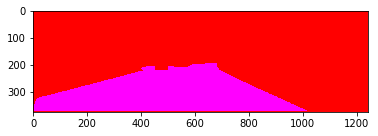

In [23]:
b = imread(train_gt_arr[100])
b[:,:,2]
plt.imshow(b)

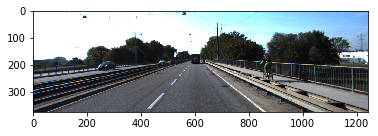

In [67]:
plt.imshow(imread(train_img_arr[100]))

In [68]:


def run():
    K.clear_session()
    
    tensorboardCB = TensorBoard(log_dir=os.path.join('tensorboard_graphs', 'fcn-keras'), histogram_freq=10, write_graph=True)
    checkpointCB = ModelCheckpoint('checkpoints/fcn.{epoch:02d}-{mean_iou:.2f}.h5', monitor=pixelwise_crossentropy, verbose=0, save_best_only=False, save_weights_only=False, mode='max', period=1)
    callbacks = [tensorboardCB, checkpointCB]
    
    IMAGE_SHAPE=(160, 576, 3)
    batch_size = 4
    steps_per_epoch = np.round(len(train_img_arr)/ batch_size)
    t_generator = train_generator(train_img_arr, train_gt_arr, batch_size)
    val_generator = train_generator(val_img_arr, val_gt_arr, batch_size)
    model_fcn = fcn_vgg_8(IMAGE_SHAPE, 2, weight_decay=5e-4)
    # freeze layers from vgg for now
    for idx, layer in enumerate(model_fcn.layers):
        if idx < 17:
            layer.trainable = False
    model_fcn.summary()
    model_fcn.compile(loss=pixelwise_crossentropy,
                  optimizer=Adam(),
                  metrics=[pixelwise_crossentropy])
    model_fcn.fit_generator(t_generator, epochs = 5, steps_per_epoch=steps_per_epoch,
#                        validation_data = val_generator, validation_steps = len(val_img_arr)//batch_size, 
                            callbacks=callbacks)

In [69]:
run()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 576, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 576, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 160, 576, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 80, 288, 64)  0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

/Users/wwymak/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


 3/68 [>.............................] - ETA: 27:07 - loss: 6203103.1667 - pixelwise_crossentropy: 6203100.8333

KeyboardInterrupt: 